In [1]:
#to make life easier
%load_ext autoreload
%autoreload 2

In [2]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings

import plotly.offline as py
py.init_notebook_mode(connected=False)
import plotly.graph_objs as go

<body>
  <p style="color:red";>Due to a scipy latest update, may have to run twice the cell below</p>
</body>


[See issue on the Github](https://github.com/HIPS/autograd/issues/501) for a quick fix

In [3]:
from src.models import Model, Prior, Conditional_model
from src.sampling import Metropolis_Hastings as MH
from src.helpers import samples_exploration,big_plot,reset_plot
from src.optimization import gradient_descent as GD

# Load the data

In [4]:
df = pd.read_csv("data/wages.dat", 
                 sep="\s+")

y_not_normalized = df.LNWAGE.values.copy()

#normalization of continuous variables
df.LNWAGE = (df.LNWAGE - np.mean(df.LNWAGE.values))/np.std(df.LNWAGE.values)
df.ED =(df.ED - np.mean(df.ED.values))/np.std(df.ED.values)
df.EX =(df.EX - np.mean(df.EX.values))/np.std(df.EX.values)

#dropping correlated variables
df = df.drop(columns = ["EXSQ","AGE"], axis = 1)


#building predictors and response matrices
predictors_name = np.array(['ED', 'SOUTH', 'NONWH', 'HISP', 'FE', 'MARR', 'MARRFE', 'EX',
        'UNION', 'MANUF', 'CONSTR', 'MANAG', 'SALES', 'CLER',
        'SERV', 'PROF'])
predictors = df[predictors_name]
y = df.LNWAGE.values
X = predictors.values

#splitting train and test
X, X_test, Y, Y_test,y, y_test = train_test_split(X, y, y_not_normalized, test_size=0.2, random_state=42)

# Exploratory analysis

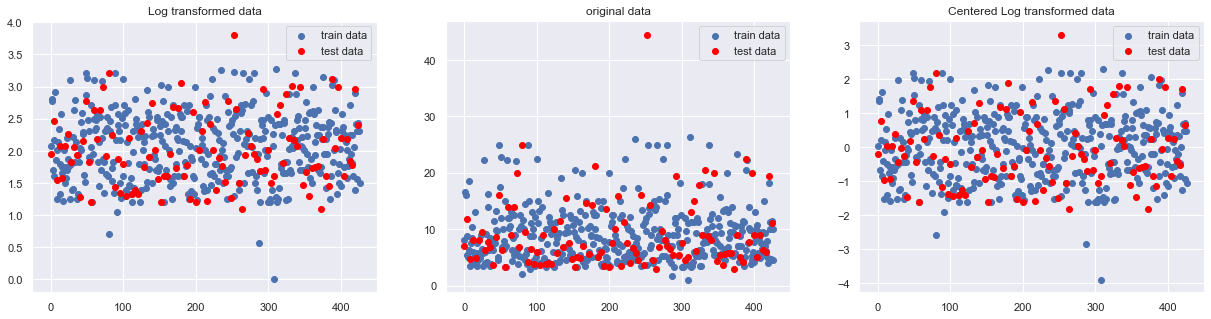

In [5]:
big_plot(21,5)
plt.subplot(132)
plt.scatter(np.arange(len(y)), np.exp(y), label = "train data")
plt.scatter(4*np.arange(len(y_test)), np.exp(y_test), label = "test data", color = "red")
plt.title("original data")
plt.legend()
plt.subplot(131)
plt.scatter(np.arange(len(y)), y, label = "train data")
plt.scatter(4*np.arange(len(y_test)), y_test, label = "test data", color = "red")
plt.title("Log transformed data")
plt.legend()
plt.subplot(133)
plt.scatter(np.arange(len(Y)), Y, label = "train data")
plt.scatter(4*np.arange(len(Y_test)), Y_test, label = "test data", color = "red")
plt.title("Centered Log transformed data")
plt.legend()
plt.show()

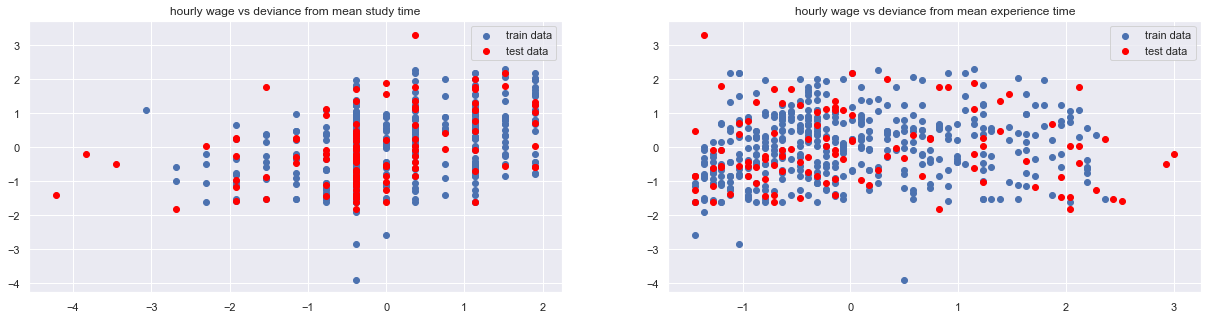

In [6]:
plt.subplot(121)
plt.scatter(X[:,0],Y,label = "train data")
plt.scatter(X_test[:,0],Y_test, label = "test data", color = "red")
plt.legend()
plt.title("hourly wage vs deviance from mean study time")
plt.subplot(122)
plt.scatter(X[:,7],Y, label = "train data")
plt.scatter(X_test[:,7],Y_test, label = "test data", color = "red")
plt.legend()
plt.title("hourly wage vs deviance from mean experience time")
plt.show()

# Create the models

In [7]:
model_gaussian = Model.Model(Prior.Gaussian_exp_prior,Conditional_model.Gaussian, Prior = [0,3,2], data = X, response = Y, additional_param = 1)
model_student = Model.Model(Prior.Gaussian_gamma_prior, Conditional_model.Student, Prior = [0,3,2,1/4], data = X, response = Y, additional_param = 1)

# Obtaining estimates

## Using Ordinary least squares as a comparison

In [8]:
beta_OLS = np.linalg.inv(X.T@X)@X.T@Y
sigma_OLS = (Y-X@beta_OLS).T@(Y-X@beta_OLS)/(len(Y)-len(beta_OLS))
theta_OLS = np.insert(beta_OLS,0,sigma_OLS)

## using MAP

In [9]:
GD.vanilla_gd(model_gaussian, max_iter= 1000)
GD.vanilla_gd(model_student, max_iter= 1000)

Progress : [====================] 100% Done...
   duration: 0:00:02
Progress : [====================] 100% Done...
   duration: 0:00:02


## Using Metropolis Hastings

#### with gaussian random walk

In [10]:
with warnings.catch_warnings(record=True):
    initial = np.random.randn(model_gaussian.size)
    initial[0]=0.5
    MH.random_walk_MH(model_gaussian, max_iter = 20000, verbose = True, step_size = 0.035, initial = initial)

Progress : [====================] 100% Done...
  Acceptance rate : 27.7%  (advised values between 10% and 50%)
  duration: 0:00:14


In [11]:
with warnings.catch_warnings(record=True):
    initial = np.random.randn(model_student.size)
    initial[0]=20
    step_size = np.ones_like(initial)*0.035
    step_size[0] = 10
    MH.random_walk_MH(model_student, max_iter = 20000, verbose = True, step_size = step_size, initial = initial)

Progress : [====================] 100% Done...
  Acceptance rate : 16.9%  (advised values between 10% and 50%)
  duration: 0:00:15


#### with Langevin correction

In [12]:
with warnings.catch_warnings(record=True):
    initial = np.ones(model_gaussian.size)
    test = MH.Langevin_MH(model_gaussian, max_iter = 20000, initial = initial,verbose = True, tau = 1e-4,RETURN=True)

Metropolis Hasting started at: 2019-06-01 18:26:23
Progress : [====================] 100% Done...
  Acceptance rate : 59.2%  (advised values between 10% and 50%)
  duration: 0:01:30


In [13]:
with warnings.catch_warnings(record=True):
    initial = np.ones(model_student.size)
    MH.Langevin_MH(model_student, max_iter = 20000, initial = initial, tau = 1e-4)

Metropolis Hasting started at: 2019-06-01 18:27:52
Progress : [====================] 100% Done...
  Acceptance rate : 73.0%  (advised values between 10% and 50%)
  duration: 0:02:06


## Comparison of the results

### extraction of the estimates from the models

In [14]:
r_gaussian = pd.DataFrame(model_gaussian.results).T
r_gaussian.columns = np.insert(predictors_name,0,"sigma")
r_gaussian = r_gaussian.T
r_gaussian.T

,sigma,ED,SOUTH,NONWH,HISP,FE,MARR,MARRFE,EX,UNION,MANUF,CONSTR,MANAG,SALES,CLER,SERV,PROF
gd,0.773999,0.343220,-0.185554,-0.215717,-0.208482,-0.309313,0.125994,-0.089408,0.258865,0.394272,0.233462,0.156569,0.447407,-0.250962,0.072440,-0.300974,0.353422
MH_vanilla_mean,0.789338,0.355517,-0.182036,-0.213002,-0.209118,-0.245228,0.167668,-0.153757,0.260073,0.387445,0.210152,0.166308,0.393328,-0.326371,0.034979,-0.342492,0.293987
MH_vanilla_median,0.789075,0.357471,-0.181532,-0.210299,-0.209173,-0.244491,0.165515,-0.151945,0.259567,0.383849,0.208906,0.159095,0.396045,-0.324167,0.030807,-0.346795,0.294884
MH_Langevin_mean,0.779202,0.352176,-0.187160,-0.207619,-0.228727,-0.239811,0.169737,-0.161826,0.257437,0.383584,0.222031,0.154408,0.386585,-0.304678,0.029928,-0.338528,0.298755
MH_Langevin_median,0.779073,0.352171,-0.187810,-0.207422,-0.225281,-0.241411,0.172391,-0.160506,0.257224,0.383480,0.219469,0.153509,0.388370,-0.302356,0.030295,-0.337388,0.296822


In [15]:
r_student = pd.DataFrame(model_student.results).T
r_student.columns = np.insert(predictors_name,0,"df")
r_student = r_student.T
r_student.T

,df,ED,SOUTH,NONWH,HISP,FE,MARR,MARRFE,EX,UNION,MANUF,CONSTR,MANAG,SALES,CLER,SERV,PROF
gd,3.334820,0.314887,-0.194772,-0.151985,-0.394906,-0.460515,0.156712,-0.014525,0.268185,0.374122,0.207392,-0.251857,0.559236,-0.122699,0.168221,-0.333917,0.447229
MH_vanilla_mean,13.374400,0.495808,-0.380037,-0.164721,-0.152542,0.799623,0.565561,0.102603,0.249821,0.763968,0.080272,-0.007520,0.523278,-0.073241,1.061858,0.649634,-0.132819
MH_vanilla_median,14.436301,0.460091,-0.396005,-0.160506,-0.114219,0.043942,0.301994,-0.038650,0.254277,0.577267,0.076493,0.045766,0.549573,-0.026530,0.306421,-0.069952,0.066520
MH_Langevin_mean,8.585255,0.341414,-0.202291,-0.232614,-0.236216,-0.244534,0.217471,-0.210877,0.263230,0.362972,0.196773,0.140688,0.469032,-0.283162,0.042313,-0.368979,0.297613
MH_Langevin_median,8.911041,0.340888,-0.202649,-0.233886,-0.241924,-0.241603,0.218720,-0.216950,0.262774,0.364220,0.196346,0.135825,0.475185,-0.286612,0.043738,-0.366519,0.297143


In [16]:
trace = []
for name in r_student.columns:
    trace0 = go.Scatter(
    y = r_student[name].values[1:],
    name = name+ " student",
    mode = 'markers',
    marker = dict(
        size = 10,
        color = 'steelblue',
        )
    )
    trace.append(trace0)
for name in r_gaussian.columns:
    trace0 = go.Scatter(
    y = r_gaussian[name].values[1:],
    name = name+ " gaussian",
    mode = 'markers',
    marker = dict(
        size = 10,
        color = 'steelblue',
        )
    )
    trace.append(trace0)

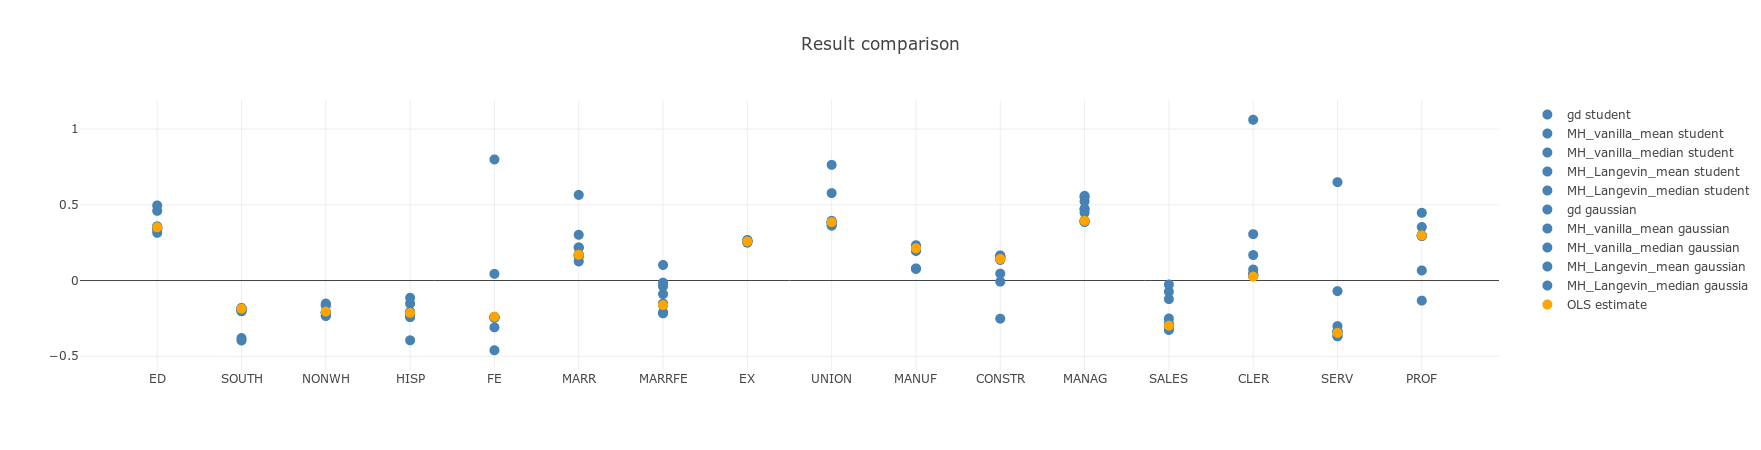

In [17]:
trace_ref = go.Scatter(
    y = theta_OLS[1:],
    name = 'OLS estimate',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = 'orange'
    )
)



trace.append(trace_ref)
data = trace

layout = dict(title = 'Result comparison',
              yaxis = dict(zeroline = True),
               xaxis = go.layout.XAxis(
                        tickmode = 'array',
                        tickvals = np.arange(0,16),
                        ticktext = predictors_name,#np.insert(predictors_name,0,"noise"),
                       zeroline = False
               )
             )

fig = dict(data=data, layout=layout)
py.iplot(fig)

# Accuracy of the prediction

error_gd_student = np.sum(np.abs(Y_test-np.dot(X_test,beta_gd_student)))/len(Y_test)
error_MH_student = np.sum(np.abs(Y_test-np.dot(X_test,beta_MH_student)))/len(Y_test)
error_gd_gaussian = np.sum(np.abs(Y_test-np.dot(X_test,beta_gd_gaussian)))/len(Y_test)
error_MH_gaussian = np.sum(np.abs(Y_test-np.dot(X_test,beta_MH_gaussian)))/len(Y_test)
print("----------------- Error on test set------------------")
print("Errors student : ")
print(" gd: {}".format(error_gd_student))
print(" MH: {}".format(error_MH_student))
print("Errors gaussian : ")
print(" gd: {}".format(error_gd_gaussian))
print(" MH: {}".format(error_MH_gaussian))

error_gd_student = np.sum(np.abs(Y-np.dot(X,beta_gd_student)))/len(Y)
error_MH_student = np.sum(np.abs(Y-np.dot(X,beta_MH_student)))/len(Y)
error_gd_gaussian = np.sum(np.abs(Y-np.dot(X,beta_gd_gaussian)))/len(Y)
error_MH_gaussian = np.sum(np.abs(Y-np.dot(X,beta_MH_gaussian)))/len(Y)
print("----------------- Error on train set------------------")
print("Errors student: ")
print(" gd: {}".format(error_gd_student))
print(" MH: {}".format(error_MH_student))
print("Errors gaussian : ")
print(" gd: {}".format(error_gd_gaussian))
print(" MH: {}".format(error_MH_gaussian))

# Classification 

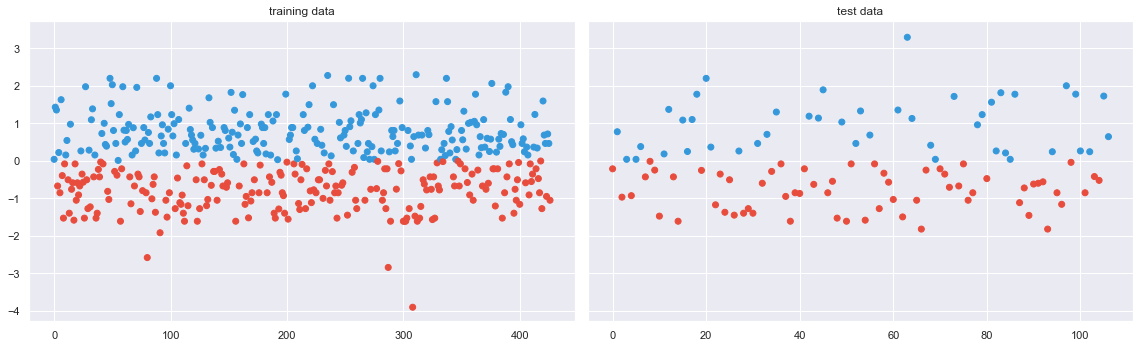

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

inter = Y
classes = inter.copy()
classes[Y >= 0] = 0
classes[Y < 0 ]= 1

#flatui = ["#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
flatui = ["#3498db", "#e74c3c", "#34495e", "#2ecc71"]

def convert(n): 
    return flatui[int(n)]
colors = list(map(convert, classes) )

axs[0].scatter(np.arange(0,X.shape[0]),Y, c = colors)
axs[0].set_title("training data")


inter = Y_test
classes_test = inter.copy()
classes_test[Y_test >= 0] = 0
classes_test[Y_test < 0 ]= 1
colors = list(map(convert, classes_test) )


axs[1].scatter(np.arange(0,X_test.shape[0]),Y_test, c = colors)
axs[1].set_title("test data")

plt.tight_layout()
plt.show()

In [19]:
multilogi = Model.Model(Prior.Gaussian_prior,Conditional_model.Multilogistic,data = X,response = classes, Prior = [0,np.clip(np.random.randn(X.shape[1]),a_min = 0.01, a_max = 10)],cond_model = [2])

In [20]:
with warnings.catch_warnings(record = True):
    initial = np.zeros(multilogi.size) + 0.1
    samples_classification = MH.random_walk_MH(multilogi, max_iter = 40000, verbose = True, step_size = 5*1e-3, initial = initial)

Progress : [====================] 100% Done...
  Acceptance rate : 49.4%  (advised values between 10% and 50%)
  duration: 0:00:45


In [21]:
results = multilogi.results["MH_vanilla_mean"]
betas = results.reshape(multilogi.cond_model.number_classes-1,multilogi.data.shape[1])
P = np.dot(X_test,betas.T)
#add the last column as the reference one for identifiability
X0 = 0.*np.zeros((P.shape[0],1))
P = np.hstack((P,X0))
#softmax
P = np.exp(P)
cste = 1/np.sum(P,axis = 1)
P = cste[:,None]*P
fitted = np.argmax(P,axis = 1)
error = 0
for pred,true in zip(fitted,classes_test):
    if pred != true:
        error+=1
P = np.dot(X,betas.T)
#add the last column as the reference one for identifiability
X0 = 0.*np.zeros((P.shape[0],1))
P = np.hstack((P,X0))
#softmax
P = np.exp(P)
cste = 1/np.sum(P,axis = 1)
P = cste[:,None]*P
fitted = np.argmax(P,axis = 1)
error_train = 0
for pred,true in zip(fitted,classes):
    if pred != true:
        error_train+=1
print("error on train set {:.2%}".format(error_train/len(classes)))
print("error on test set {:.2%}".format(error/len(classes_test)))

error on train set 34.66%
error on test set 29.91%


In [22]:
trace_theta, trace_energy, trace_lambdas = GD.Wolfe_cond_gd(model_gaussian, max_iter = 4000, trace = True, c1 = 1e-1, initial= 0.5*np.ones(model_gaussian.size))

Progress : [====================] 100% Done...
 1.3100205086376225e-06  duration: 0:00:30


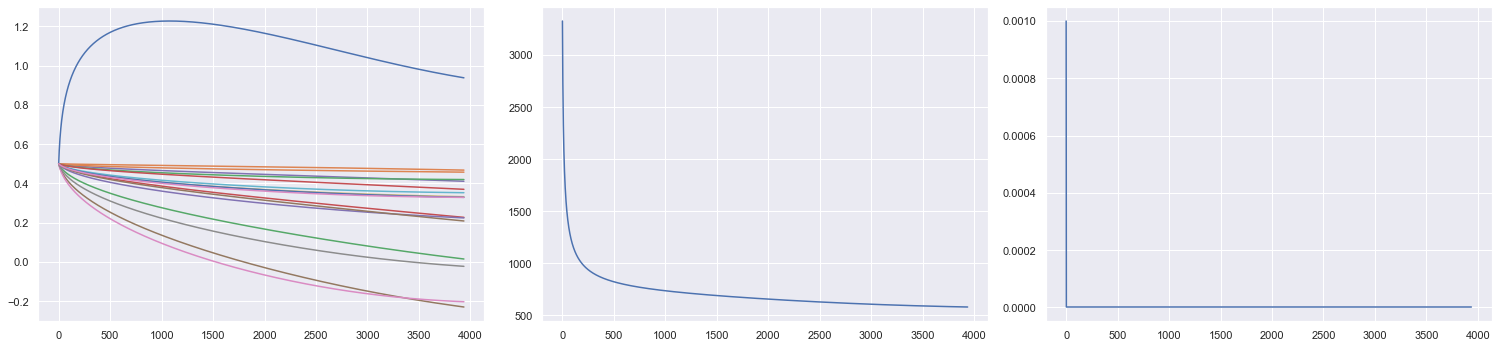

In [23]:
plt.subplot(131)
plt.plot(trace_theta)
plt.subplot(132)
plt.plot(trace_energy)
plt.subplot(133)
plt.plot(trace_lambdas)
plt.tight_layout()
plt.show()

In [24]:
trace_theta, trace_energy, trace_lambdas = GD.Wolfe_cond_gd(model_student, max_iter = 4000, trace = True, c1 = 1e-1, initial= 0.5*np.ones(model_gaussian.size))

Progress : [====================] 100% Done...
 0.00016677181699666576  duration: 0:00:40


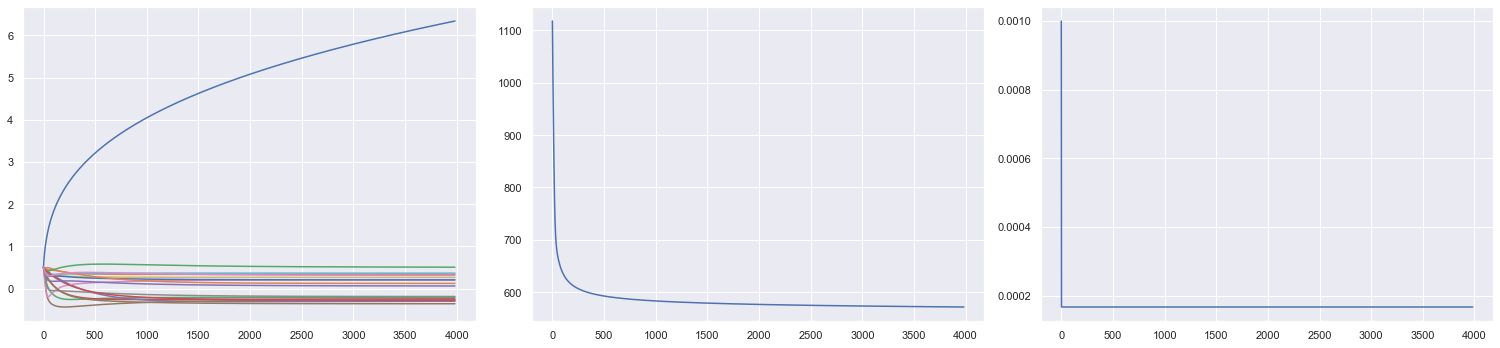

In [25]:
plt.subplot(131)
plt.plot(trace_theta)
plt.subplot(132)
plt.plot(trace_energy)
plt.subplot(133)
plt.plot(trace_lambdas)
plt.tight_layout()
plt.show()

In [27]:
values, energies = GD.line_search_gd(model_student, lambda_ = 1e-2,x0 = np.ones(model_student.size),max_iter = 4000, trace = True)

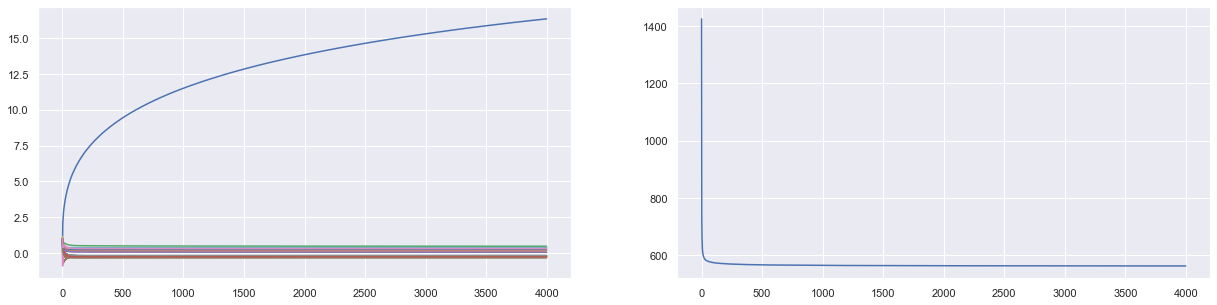

In [28]:
plt.subplot(121)
plt.plot(values)
plt.subplot(122)
plt.plot(energies)
plt.show()

In [35]:
from src.approximation import Laplace

In [52]:
Laplace.laplace_approx(model_gaussian, integral_value=True,force=False)

[[-1.66998115e+227  6.24370154e+225 -6.01826415e+223  8.07925281e+225
  -3.60085389e+225  5.19202365e+226  3.25009385e+226 -5.38714113e+226
  -4.35551551e+224 -6.28112197e+225 -1.52348279e+226 -1.07635568e+226
  -3.95121855e+226 -3.47870189e+226 -3.44556965e+226 -3.27387577e+226
  -4.11830379e+226]
 [ 6.24370154e+225 -6.91555026e+227 -2.08132934e+227 -9.63285752e+226
  -2.55795500e+227 -4.03357575e+227 -2.83292121e+227  3.26515238e+227
  -1.58115168e+227  3.72841768e+226 -2.71325391e+226 -1.85376268e+227
   8.67645561e+227  4.78089539e+227  4.20416312e+227  1.34822761e+227
   1.01367766e+228]
 [-6.01826415e+223 -2.08132934e+227 -1.64650361e+228  4.13023949e+227
   3.99850000e+227  2.60761306e+227  3.58809406e+227 -4.36266257e+227
  -1.34257892e+227 -1.79202344e+227 -2.68241288e+226  3.46412796e+227
   2.71118244e+227  3.69268466e+227  2.76609342e+227  1.83890390e+227
   2.80711423e+227]
 [ 8.07925281e+225 -9.63285752e+226  4.13023949e+227 -3.12776668e+228
  -4.91900084e+227 -5.82919713

/home/charles/Desktop/Bayesian computation/projet_bayesian/src/approximation/Laplace.py:23: RuntimeWarning:

divide by zero encountered in double_scalars



inf